In [1]:
# Header

In [2]:
import numpy as np
import pandas as pd

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------

# Final columns to keep for the aggregated dataset
KEEP_COLS = [
    "Team","Season","Wins","PointDiff","FG%","3P%","FT%","3PAr","FTr","eFG%","TS%",
    "REB","OREB%","DREB%","AST/TOV","TOV%","ORtg","DRtg","NetRtg","PACE"
]

# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------

def safe_div(n, d):
    """
    Safely divide two arrays, returning NaN for division by zero.
    """
    n = np.asarray(n, dtype="float64")
    d = np.asarray(d, dtype="float64")
    
    # Suppress runtime warnings for invalid division
    with np.errstate(divide="ignore", invalid="ignore"):
        out = n / d
    
    # Set results of invalid divisions (e.g., 0/0) to NaN
    out[~np.isfinite(out)] = np.nan
    return out

def _norm_header(s):
    """
    Standardize a column header string by stripping whitespace.
    """
    return s.replace("\n", " ").strip()

# -----------------------------------------------------------------------------
# Date & Season Labeling
# -----------------------------------------------------------------------------

def _parse_game_date(df):
    """
    Try multiple date parsing patterns to handle inconsistent formats.
    All dates are converted to UTC.
    """
    s = df["gameDate"].astype(str).str.strip()

    # Try ISO or YYYY-MM-DD HH:MM:SS
    dt = pd.to_datetime(s, errors="coerce", utc=True)

    # Fill NaTs by trying MM/DD/YYYY and similar US-style formats
    mask = dt.isna()
    if mask.any():
        dt2 = pd.to_datetime(s[mask], format="%m/%d/%Y %I:%M %p", errors="coerce", utc=True)
        dt.loc[mask] = dt2

    # Try a final fallback parse
    mask = dt.isna()
    if mask.any():
        dt3 = pd.to_datetime(s[mask], errors="coerce", utc=True, infer_datetime_format=True)
        dt.loc[mask] = dt3

    return dt


def _label_nba_season(dt):
    """
    Labels a game date with its corresponding NBA season (e.g., "2022-23").
    Uses July 1st as the boundary for a new season.
    """
    y = dt.dt.year
    m = dt.dt.month
    
    # If the month is before July (1-6), it belongs to the *previous* start year
    start_year = y.where(m >= 7, y - 1)
    
    # Format as "YYYY-YY"
    return (start_year.astype(int).astype(str) + "-" +
            ((start_year + 1) % 100).astype(str).str.zfill(2))

# -----------------------------------------------------------------------------
# Historical Data Processing (Past Seasons)
# -----------------------------------------------------------------------------

def filter_past_games(df, start_str="2019-10-22"):
    """
    Filters the raw game-by-game dataset to the relevant time frame.
    """
    d = df.copy()
    d.columns = d.columns.str.strip()
    
    if "gameDate" not in d.columns:
        raise KeyError("Expected 'gameDate' column in TeamStatistics CSV.")
        
    d["game_dt"] = _parse_game_date(d)
    start = pd.Timestamp(start_str, tz="UTC")
    end = d["game_dt"].max()  # Most recent date in *this* file
    
    d = d.loc[d["game_dt"].between(start, end)].copy()
    return d

def aggregate_team_season(past_filtered):
    """
    Aggregates game-by-game stats to the Team x Season level.
    This function processes the historical data.
    """
    d = past_filtered.copy()

    # Label season
    d["Season"] = _label_nba_season(d["game_dt"])

    # Normalize team column
    team_col = "teamName" if "teamName" in d.columns else ("Team" if "Team" in d.columns else None)
    if not team_col:
        raise KeyError("Could not find a team column (expected 'teamName' or 'Team').")
    d = d.rename(columns={team_col: "Team"})

    # Create component variables for feature engineering
    
    # Possessions formula
    d["_poss"] = (
        pd.to_numeric(d.get("fieldGoalsAttempted"), errors="coerce")
        - pd.to_numeric(d.get("reboundsOffensive"), errors="coerce")
        + pd.to_numeric(d.get("turnovers"), errors="coerce")
        + 0.44 * pd.to_numeric(d.get("freeThrowsAttempted"), errors="coerce")
    )

    # Numeric aliases for aggregation
    d["_pts"] = pd.to_numeric(d.get("teamScore"), errors="coerce")
    d["_opp"] = pd.to_numeric(d.get("opponentScore"), errors="coerce")
    d["_fga"] = pd.to_numeric(d.get("fieldGoalsAttempted"), errors="coerce")
    d["_fgm"] = pd.to_numeric(d.get("fieldGoalsMade"), errors="coerce")
    d["_3pa"] = pd.to_numeric(d.get("threePointersAttempted"), errors="coerce")
    d["_3pm"] = pd.to_numeric(d.get("threePointersMade"), errors="coerce")
    d["_fta"] = pd.to_numeric(d.get("freeThrowsAttempted"), errors="coerce")
    d["_or"]  = pd.to_numeric(d.get("reboundsOffensive"), errors="coerce")
    d["_dr"]  = pd.to_numeric(d.get("reboundsDefensive"), errors="coerce")
    d["_reb"] = pd.to_numeric(d.get("reboundsTotal"), errors="coerce")
    d["_ast"] = pd.to_numeric(d.get("assists"), errors="coerce")
    d["_tov"] = pd.to_numeric(d.get("turnovers"), errors="coerce")
    d["win"]  = pd.to_numeric(d.get("win"), errors="coerce") # Ensure 'win' is numeric

    # Check for optional source columns
    has_ft_pct = "freeThrowsPercentage" in d.columns
    has_wins = "win" in d.columns # *** Use the 'win' column for reliability ***

    # Aggregate to Team × Season
    agg_dict = {
        "_pts":"mean","_opp":"mean","_fga":"mean","_fgm":"mean","_3pa":"mean","_3pm":"mean","_fta":"mean",
        "_or":"mean","_dr":"mean","_reb":"mean","_ast":"mean","_tov":"mean","_poss":"mean"
    }
    
    # Add optional aggregations
    if has_ft_pct:
        agg_dict["freeThrowsPercentage"] = "mean"
    if has_wins:
        agg_dict["win"] = "sum" # *** Sum the 'win' column (1s and 0s) ***

    agg = d.groupby(["Team","Season"]).agg(agg_dict).reset_index()

    # Standardize aggregated names
    if has_ft_pct:
        agg = agg.rename(columns={"freeThrowsPercentage":"FT_pct_src"})
    else:
        agg["FT_pct_src"] = np.nan
        
    if has_wins:
        agg = agg.rename(columns={"win":"Wins"}) # *** Rename 'win' to 'Wins' ***
    else:
        agg["Wins"] = np.nan # Fallback if 'win' column was missing

    # Feature Engineering (calculating the final metrics)
    agg["PointDiff"] = agg["_pts"] - agg["_opp"]
    agg["FG%"]  = safe_div(agg["_fgm"], agg["_fga"]) * 100
    agg["3P%"]  = safe_div(agg["_3pm"], agg["_3pa"]) * 100
    agg["FT%"]  = pd.to_numeric(agg["FT_pct_src"], errors="coerce") * 100 # Assume src is decimal
    agg["3PAr"] = safe_div(agg["_3pa"], agg["_fga"])
    agg["FTr"]  = safe_div(agg["_fta"], agg["_fga"])
    agg["eFG%"] = safe_div(agg["_fgm"] + 0.5*agg["_3pm"], agg["_fga"])
    agg["TS%"]  = safe_div(agg["_pts"], 2*(agg["_fga"] + 0.44*agg["_fta"]))
    agg["REB"]   = agg["_reb"]
    agg["OREB%"] = safe_div(agg["_or"], agg["_reb"])
    agg["DREB%"] = safe_div(agg["_dr"], agg["_reb"])
    agg["AST/TOV"] = safe_div(agg["_ast"], agg.get("_tov", np.nan))
    agg["TOV%"]    = safe_div(agg.get("_tov", np.nan), agg["_poss"])
    agg["ORtg"]  = safe_div(agg["_pts"], agg["_poss"]) * 100
    agg["DRtg"]  = safe_div(agg["_opp"], agg["_poss"]) * 100
    agg["NetRtg"] = agg["ORtg"] - agg["DRtg"]
    agg["PACE"]  = agg["_poss"]

    out = agg.reindex(columns=KEEP_COLS).sort_values(["Season","Team"]).reset_index(drop=True)
    return out

# -----------------------------------------------------------------------------
# Current Season Data Processing
# -----------------------------------------------------------------------------

def build_current_features(df):
    """
    Builds the same feature set for the 2025-26 (current) season data.
    This file has a different structure, so it needs its own processor.
    """
    d = df.copy()
    d.columns = [_norm_header(c) for c in d.columns]
    d = d.rename(columns={c: c.lower() for c in d.columns})

    # Find team column
    if "team" not in d.columns:
        for cand in ["teamname","team_name","TEAM","Team"]:
            if cand in df.columns:
                d["team"] = df[cand]
                break
        else:
            raise KeyError("Expected a TEAM column in the 2025–26 CSV ('team' or similar).")

    # Standardize column name aliases
    if "fg" in d.columns and "fgm" not in d.columns: d = d.rename(columns={"fg":"fgm"})
    if "3p" in d.columns and "3pm" not in d.columns: d = d.rename(columns={"3p":"3pm"})

    # Calculate possessions if possible
    if all(c in d.columns for c in ["fga","or","to","fta"]):
        d["_poss"] = d["fga"] - d["or"] + d["to"] + 0.44 * d["fta"]
    else:
        d["_poss"] = np.nan

    # Aggregate to team level (assuming 1 row per team, but groupby is safer)
    mean_cols = [c for c in [
        "pts","oeff","deff","pace","or","dr","tot","a","st","to","bl",
        "fga","fgm","3pa","3pm","fta","ft%","_poss"
    ] if c in d.columns]

    curr = d.groupby("team")[mean_cols].mean(numeric_only=True).reset_index().rename(columns={"team":"Team"})
    curr["Season"] = "2025-26" # Manually label the season

    # Feature Engineering
    curr["FG%"]  = safe_div(curr.get("fgm", np.nan), curr.get("fga", np.nan)) * 100
    curr["3P%"]  = safe_div(curr.get("3pm", np.nan), curr.get("3pa", np.nan)) * 100
    curr["3PAr"] = safe_div(curr.get("3pa", np.nan), curr.get("fga", np.nan))
    curr["FTr"]  = safe_div(curr.get("fta", np.nan), curr.get("fga", np.nan))
    curr["eFG%"] = safe_div(curr.get("fgm", np.nan) + 0.5*curr.get("3pm", np.nan), curr.get("fga", np.nan))
    
    if all(c in curr.columns for c in ["pts","fga","fta"]):
        curr["TS%"] = safe_div(curr["pts"], 2*(curr["fga"] + 0.44*curr["fta"]))
    else:
        curr["TS%"] = np.nan

    curr["REB"]   = curr.get("tot", np.nan)
    curr["OREB%"] = safe_div(curr.get("or", np.nan), curr["REB"])
    curr["DREB%"] = safe_div(curr.get("dr", np.nan), curr["REB"])
    curr["AST/TOV"] = safe_div(curr.get("a", np.nan), curr.get("to", np.nan))
    curr["TOV%"]    = safe_div(curr.get("to", np.nan), curr.get("_poss", np.nan))

    # Use 'oeff'/'deff' if available, otherwise calculate
    curr["ORtg"]  = curr["oeff"] if "oeff" in curr.columns else safe_div(curr.get("pts", np.nan), curr.get("_poss", np.nan)) * 100
    curr["DRtg"]  = curr["deff"] if "deff" in curr.columns else np.nan
    curr["NetRtg"] = curr["ORtg"] - curr["DRtg"]
    curr["PACE"]  = curr["pace"] if "pace" in curr.columns else curr.get("_poss", np.nan)

    # Current file won't have reliable season Wins / PointDiff
    curr["FT%"]       = curr["ft%"] if "ft%" in curr.columns else np.nan
    curr["PointDiff"] = np.nan
    curr["Wins"]      = np.nan

    out = curr.reindex(columns=KEEP_COLS).sort_values("Team").reset_index(drop=True)
    return out

# -----------------------------------------------------------------------------
# Main Orchestration Function
# -----------------------------------------------------------------------------

def merge_all(past_data, curr_data):
    """
    Runs the full data processing pipeline:
    1. Loads and filters the historical game-by-game data.
    2. Aggregates historical data to the Team-Season level.
    3. Loads and processes the current (2025-26) season data.
    4. Combines the two datasets, ensuring no duplicate seasons.
    5. Returns a final, clean DataFrame ready for modeling.
    """
    
    # Process historical data
    past_filtered = filter_past_games(past_data)
    past_features = aggregate_team_season(past_filtered)
    
    # Process current season data
    curr_features = build_current_features(curr_data)  # Season == "2025-26"

    # Avoid duplicates if historical data already contains the current season
    
    # Find the label for the most recent season in the historical file
    last_dt = past_filtered["game_dt"].max()
    last_season_year = last_dt.year if last_dt.month >= 7 else last_dt.year - 1
    last_season_label = f"{last_season_year}-{str((last_season_year + 1) % 100).zfill(2)}"

    # Drop that season from the historical set, as the 'curr_data' is the source of truth
    past_no_current = past_features[past_features["Season"] != last_season_label]

    # Merge the two parts
    df = pd.concat([past_no_current, curr_features], ignore_index=True)

    # Final Tidy
    df["Team"] = df["Team"].astype(str).str.strip()
    df["Season"] = df["Season"].astype(str)

    # Enforce a single row per Team×Season, averaging any accidental duplicates
    num_cols = df.select_dtypes(include="number").columns.tolist()
    agg_dict = {c: "mean" for c in num_cols}
    
    # Keep the first occurrence for non-numerics
    agg_dict.update({"Team": "first", "Season": "first"})

    df = (
        df.groupby(["Team", "Season"], as_index=False)
          .agg(agg_dict)
          .reindex(columns=KEEP_COLS)
          .sort_values(["Season", "Team"])
          .reset_index(drop=True)
    )

    return df

In [3]:
# Initialize `final` 
import pandas as pd

data1 = pd.read_csv("https://raw.githubusercontent.com/rheanibert04/Group1-STA4724/refs/heads/main/TeamStatistics%20copy.csv")
data2 = pd.read_csv("https://raw.githubusercontent.com/rheanibert04/Group1-STA4724/refs/heads/main/nba-25%3A26%20copy.csv")

data1["win"].head()

0    0
1    1
2    0
3    1
4    1
Name: win, dtype: int64

In [4]:
# build merge dataset
final = merge_all(data1, data2)

# quick sanity checks
print(final["Season"].value_counts().sort_index())
print(final.groupby("Season")["Team"].nunique().sort_index())
final.info()





Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: count, dtype: int64
Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: Team, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Team       210 non-null    object 
 1   Season     210 non-null    object 
 2   Wins       180 non-null    float64
 3   PointDiff  180 non-null    float64
 4   FG%        210 non-null    float64
 5   3P%        210 non-null    float64
 6   FT%        180 non-null    float64
 7   3PAr       210 non-null    float64
 8   FTr        210 non-null    float64
 9   eFG%       210 non-null    float64
 10  TS%        210 non-null    float64
 11  REB        210 non-null    float64
 12  OREB%      210 non-null    float64
 13  DREB%      210 non-null    fl

/var/folders/zz/hf6r7jz11fz9mxt9h_4m9knh0000gn/T/ipykernel_58634/427912382.py:62: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt3 = pd.to_datetime(s[mask], errors="coerce", utc=True, infer_datetime_format=True)


In [5]:
# save dataset
final.to_csv("../data/final_csv.csv", index=False)
print("Saved ../data/final_csv.csv")



Saved ../data/final_csv.csv


In [6]:
# Data cleaning break down
"""
Importing and Exploring the Raw Data

    Loaded two datasets:

    TeamStatistics.csv → contains team-level game data (2019–2025)

    nba-25:26.csv → contains current 2025–26 season data

    Checked structure and columns using df.info() and df.head()

    Verified date range, missing values, and column names

Filtering Relevant Seasons

    Extracted all games from October 22, 2019 up to the most recent game in the dataset

    Used pd.to_datetime() to convert game dates to proper datetime format

    Created a new Season column (e.g., “2019–20”, “2020–21”) based on NBA’s July 1 season boundary

Cleaning & Standardizing Columns

    Stripped extra spaces and fixed inconsistent column names (e.g., "teamName" → "Team", "seasonWins" → "Wins")

    Converted numeric columns to proper data types using pd.to_numeric()

    Removed unnecessary text characters and null values (NaNs)

Creating Key Statistical Variables
    Computed advanced metrics used in modeling:

    Field Goal % (FG%) = FGM / FGA

    3-Point % (3P%) = 3PM / 3PA

    Free Throw % (FT%) = FTM / FTA

    Effective FG% (eFG%) = (FGM + 0.5×3PM) / FGA

    True Shooting % (TS%) = PTS / (2 × (FGA + 0.44×FTA))

    Turnover % (TOV%), Assist/Turnover ratio (AST/TOV)

    Offensive & Defensive Ratings (ORtg, DRtg) and Net Rating

Aggregating by Team and Season

    Grouped by Team and Season using groupby()

    Computed per-game averages and totals for all major stats

    Created one clean row per team per season

Merging Historical + Current Data

    Combined past seasons with the 2025–26 data using pd.concat()

    Dropped duplicate rows for the current season to prevent double counting

    Exported final cleaned file as final_csv.csv to /data/

Final Dataset Overview

    Covers 2019–20 through 2025–26 seasons

    Includes 20+ cleaned, numeric variables

    Ready for Exploratory Data Analysis (EDA) and modeling
"""

'\nImporting and Exploring the Raw Data\n\n    Loaded two datasets:\n\n    TeamStatistics.csv → contains team-level game data (2019–2025)\n\n    nba-25:26.csv → contains current 2025–26 season data\n\n    Checked structure and columns using df.info() and df.head()\n\n    Verified date range, missing values, and column names\n\nFiltering Relevant Seasons\n\n    Extracted all games from October 22, 2019 up to the most recent game in the dataset\n\n    Used pd.to_datetime() to convert game dates to proper datetime format\n\n    Created a new Season column (e.g., “2019–20”, “2020–21”) based on NBA’s July 1 season boundary\n\nCleaning & Standardizing Columns\n\n    Stripped extra spaces and fixed inconsistent column names (e.g., "teamName" → "Team", "seasonWins" → "Wins")\n\n    Converted numeric columns to proper data types using pd.to_numeric()\n\n    Removed unnecessary text characters and null values (NaNs)\n\nCreating Key Statistical Variables\n    Computed advanced metrics used in mod

In [7]:
# Basic EDA

In [8]:
# summary

final.select_dtypes(include="number").describe().T

final.drop(columns=["PointDiff", "NetRtg", "ORtg", "DRtg"], inplace=True)

In [9]:
# quick overview
final.info()
final.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Team     210 non-null    object 
 1   Season   210 non-null    object 
 2   Wins     180 non-null    float64
 3   FG%      210 non-null    float64
 4   3P%      210 non-null    float64
 5   FT%      180 non-null    float64
 6   3PAr     210 non-null    float64
 7   FTr      210 non-null    float64
 8   eFG%     210 non-null    float64
 9   TS%      210 non-null    float64
 10  REB      210 non-null    float64
 11  OREB%    210 non-null    float64
 12  DREB%    210 non-null    float64
 13  AST/TOV  210 non-null    float64
 14  TOV%     210 non-null    float64
 15  PACE     210 non-null    float64
dtypes: float64(14), object(2)
memory usage: 26.4+ KB


,Team,Season,Wins,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,PACE
0,76ers,2019-20,39.0,46.500614,36.159844,74.563077,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,101.267692
1,Bucks,2019-20,53.0,47.739541,35.577689,73.776923,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,107.188923
2,Bulls,2019-20,22.0,44.654634,34.750219,75.189231,0.396043,0.231170,0.515359,0.547016,41.861538,0.249908,0.750092,1.502488,0.150605,102.662769
3,Cavaliers,2019-20,19.0,45.826772,35.120773,75.740000,0.362205,0.226772,0.521872,0.552724,44.246154,0.244784,0.755216,1.397950,0.161251,102.372923
4,Celtics,2019-20,43.0,45.928509,36.255708,80.287500,0.381866,0.254752,0.528509,0.566963,45.968750,0.232155,0.767845,1.671249,0.132920,102.622500
5,Clippers,2019-20,44.0,46.419237,36.646255,79.300000,0.369925,0.292560,0.531974,0.573964,47.953125,0.228413,0.771587,1.613108,0.140716,105.043125
6,Grizzlies,2019-20,32.0,46.998140,35.165924,75.950769,0.341451,0.234061,0.530019,0.561258,46.707692,0.223650,0.776350,1.771169,0.145136,105.153231
7,Hawks,2019-20,20.0,44.882149,33.319536,78.835821,0.398220,0.258118,0.515164,0.554171,43.253731,0.228088,0.771912,1.477901,0.151232,107.179701
8,Heat,2019-20,41.0,46.955888,38.322296,77.435385,0.412869,0.297667,0.548669,0.587475,44.538462,0.190674,0.809326,1.744835,0.146212,101.854154
9,Hornets,2019-20,23.0,43.412102,35.186015,74.864615,0.399391,0.251701,0.504386,0.538871,42.784615,0.257102,0.742898,1.632244,0.147391,99.056000


In [10]:
# numeric summary
num_desc = final.select_dtypes(include="number").describe().T
num_desc


,count,mean,std,min,25%,50%,75%,max
Wins,180.0,44.100000,15.735985,15.000000,32.750000,44.000000,54.000000,87.000000
FG%,210.0,46.575519,1.824618,40.384615,45.626161,46.615426,47.571146,52.661064
3P%,210.0,35.866773,1.902450,27.906977,34.696545,36.009192,36.967215,42.207792
FT%,180.0,77.679089,2.533662,69.687879,75.943959,77.567054,79.418231,84.224272
3PAr,210.0,0.399842,0.042095,0.311107,0.367920,0.393638,0.425542,0.530331
FTr,210.0,0.259969,0.031134,0.199881,0.241725,0.253228,0.270418,0.406312
eFG%,210.0,0.537503,0.021002,0.453297,0.526471,0.536947,0.551551,0.599548
TS%,210.0,0.572979,0.020542,0.500626,0.561101,0.573543,0.585058,0.643180
REB,210.0,44.134462,2.290866,36.000000,42.807692,44.000000,45.431969,51.723077
OREB%,210.0,0.239248,0.030004,0.183522,0.220501,0.233028,0.254248,0.349693


In [11]:
# check for missing values
final.isna().sum().sort_values(ascending=False)

# some missing games due to current active season

Wins       30
FT%        30
Team        0
Season      0
FG%         0
3P%         0
3PAr        0
FTr         0
eFG%        0
TS%         0
REB         0
OREB%       0
DREB%       0
AST/TOV     0
TOV%        0
PACE        0
dtype: int64

In [12]:
# numeric correlation 
num = final.select_dtypes(include="number")
corr_with_wins = num.corr().loc[:, "Wins"].sort_values(ascending=False)
corr_with_wins


Wins       1.000000
TS%        0.689675
eFG%       0.682564
FG%        0.591578
3P%        0.585161
AST/TOV    0.517873
FT%        0.324699
3PAr       0.194865
DREB%      0.173447
REB        0.152315
FTr        0.008785
OREB%     -0.173935
PACE      -0.357748
TOV%      -0.461153
Name: Wins, dtype: float64

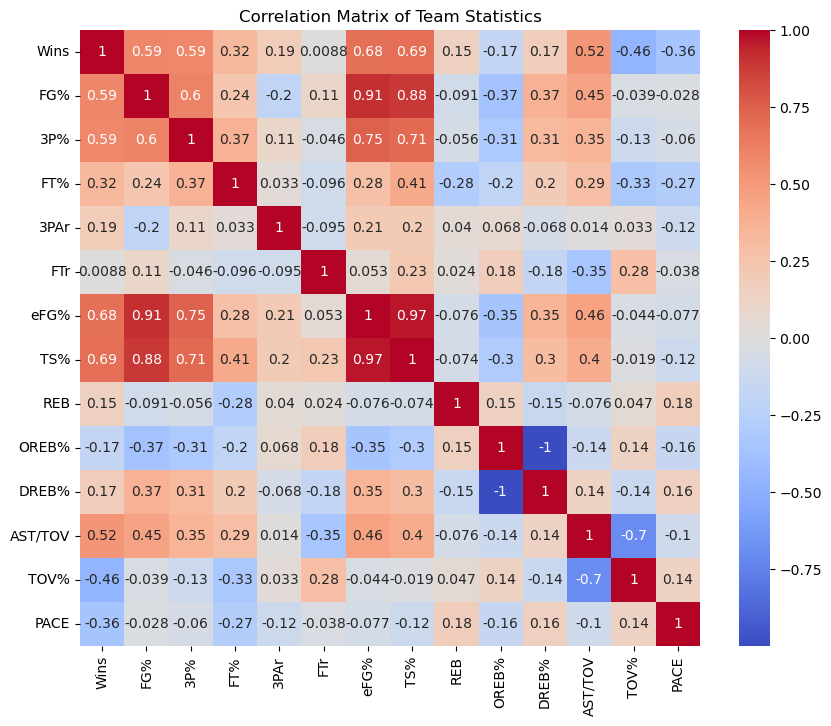

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = final.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.title("Correlation Matrix of Team Statistics")

# save image
# plt.savefig("../reports/corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


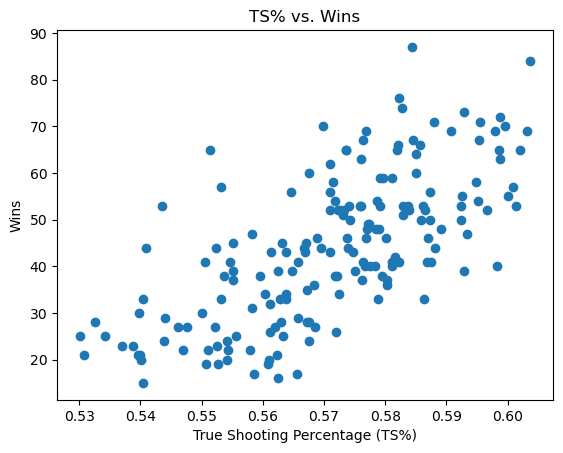

In [14]:
plt.scatter(final["TS%"], final["Wins"])
plt.xlabel("True Shooting Percentage (TS%)")
plt.ylabel("Wins")
plt.title("TS% vs. Wins")
plt.show()

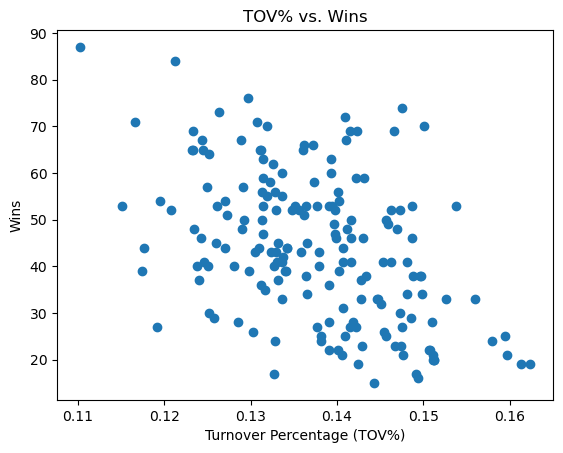

In [15]:
plt.scatter(final["TOV%"], final["Wins"])
plt.xlabel("Turnover Percentage (TOV%)")
plt.ylabel("Wins")
plt.title("TOV% vs. Wins")
plt.show()

In [16]:
# using a baseline multiple linear regression model to see how much does each stat contribute to a win
# Cell 1 — baseline linear regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare data
model_data = final.dropna(subset=["Wins"]).copy()
X = model_data.drop(columns=["Wins", "Team", "Season"])
y = model_data["Wins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train & evaluate
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Coefficients (feature influence)
coef = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
coef


R²: 0.6219466733261224
MAE: 7.041210197041386


TS%         829.660623
3PAr        114.951373
FG%           5.775655
AST/TOV       4.804392
REB           2.965423
3P%           0.127591
FT%          -0.086240
PACE         -2.521066
FTr         -38.376365
TOV%       -326.645765
eFG%       -759.055617
OREB%     -2806.182847
DREB%     -2807.264778
dtype: float64

In [17]:
# ridge regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
)
ridge.fit(X_train, y_train)

y_pred_r = ridge.predict(X_test)

print("R²:", r2_score(y_test, y_pred_r))
print("MAE:", mean_absolute_error(y_test, y_pred_r))

importance = pd.Series(
    ridge.named_steps['ridgecv'].coef_,
    index=X.columns
).sort_values(ascending=False)
importance


R²: 0.6195668879478782
MAE: 7.108713068217902


REB        4.757764
TS%        3.158641
eFG%       2.911143
FG%        2.674623
3PAr       1.720128
FT%        1.455484
AST/TOV    1.405507
FTr        0.907989
OREB%      0.003984
DREB%     -0.125047
3P%       -0.199631
TOV%      -2.863817
PACE      -4.617466
dtype: float64

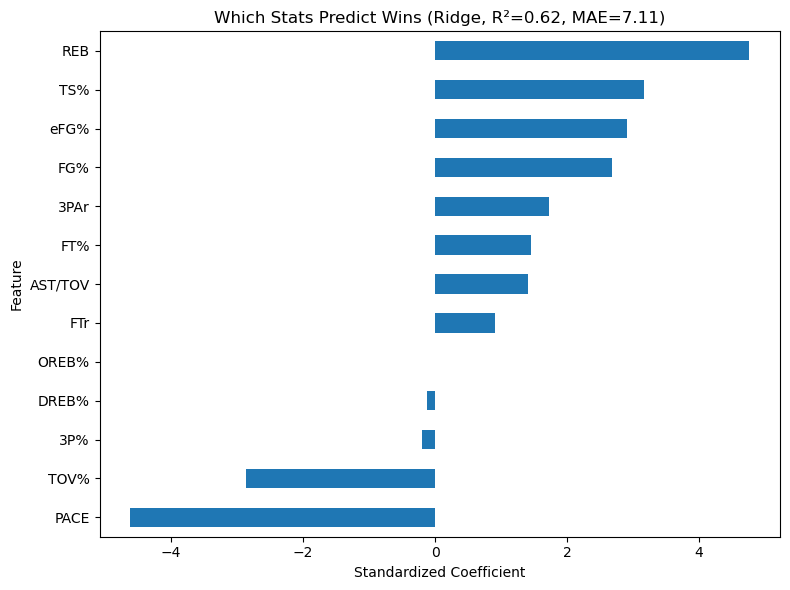

In [18]:
# feature importance (RidgeCV + scaling)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error

# load the merged data (or re-use `final` if it's already in memory)
# final = pd.read_csv("../data/final_csv.csv")

# training set = completed seasons only
model_df = final.dropna(subset=["Wins"]).copy()
X = model_df.drop(columns=["Wins","Team","Season"])
y = model_df["Wins"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# standardized coefficients (comparable importance)
imp = pd.Series(ridge.named_steps["ridgecv"].coef_, index=X.columns).sort_values()

plt.figure(figsize=(8,6))
imp.plot(kind="barh")
plt.xlabel("Standardized Coefficient")
plt.ylabel("Feature")
plt.title(f"Which Stats Predict Wins (Ridge, R²={r2:.2f}, MAE={mae:.2f})")
plt.tight_layout()

# save image
# plt.savefig("../reports/feature_importance_ridge.png", dpi=150)
plt.show()

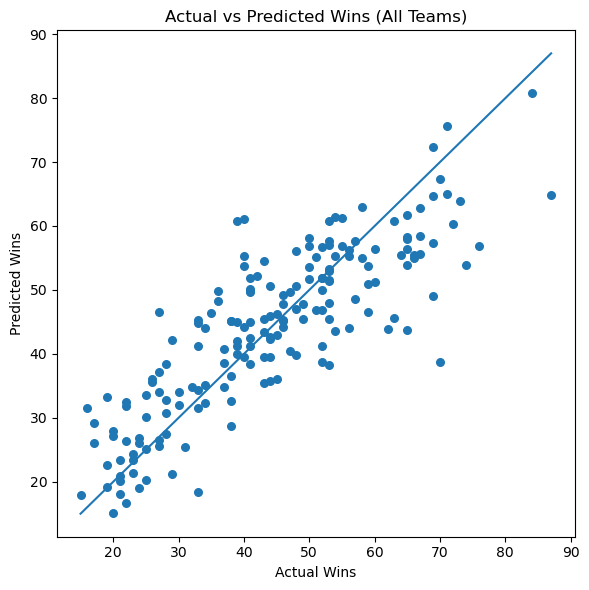

In [19]:
# Actual vs Predicted wins
import matplotlib.pyplot as plt
import numpy as np

# visualize how the model performs across the entire dataset
y_all_pred = ridge.predict(X)
plt.figure(figsize=(6,6))
plt.scatter(y, y_all_pred, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Actual vs Predicted Wins (All Teams)")
plt.tight_layout()
plt.show()


# save image
# plt.savefig("../reports/pred_vs_actual_ridge.png", dpi=150)
plt.show()


In [20]:
# Next Steps
""""
Descriptive - describe(), histograms, means
Correlation - heatmap, corr with Wins
Relationships - scatterplots, trend lines
Season Trend - groupby season, lineplots
Modeling - R², MAE, coefficient ranking
Visuals - importance bar chart, actual vs predicted
Extras - PCA, clustering, residual plots
Decision Tree to capture nonlinearity
"""

'"\nDescriptive - describe(), histograms, means\nCorrelation - heatmap, corr with Wins\nRelationships - scatterplots, trend lines\nSeason Trend - groupby season, lineplots\nModeling - R², MAE, coefficient ranking\nVisuals - importance bar chart, actual vs predicted\nExtras - PCA, clustering, residual plots\nDecision Tree to capture nonlinearity\n'